检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15
创建了具有15个输出类别的模型
开始训练 ReLU 模型，共 150 轮...
Epoch 1/150, Train Loss: 2.6116, Train IoU: 0.0225, Train Dice: 0.0388, Val Loss: 2.6321, Val IoU: 0.0005, Val Dice: 0.0011
Epoch 2/150, Train Loss: 2.3724, Train IoU: 0.0562, Train Dice: 0.0825, Val Loss: 2.4798, Val IoU: 0.0439, Val Dice: 0.0599
Epoch 3/150, Train Loss: 2.2036, Train IoU: 0.0732, Train Dice: 0.1013, Val Loss: 2.2566, Val IoU: 0.0769, Val Dice: 0.1055
Epoch 4/150, Train Loss: 2.0561, Train IoU: 0.0838, Train Dice: 0.1097, Val Loss: 2.0109, Val IoU: 0.0933, Val Dice: 0.1190
Epoch 5/150, Train Loss: 1.9166, Train IoU: 0.0907, Train Dice: 0.1141, Val Loss: 1.8103, Val IoU: 0.1007, Val Dice: 0.1240
Epoch 6/15

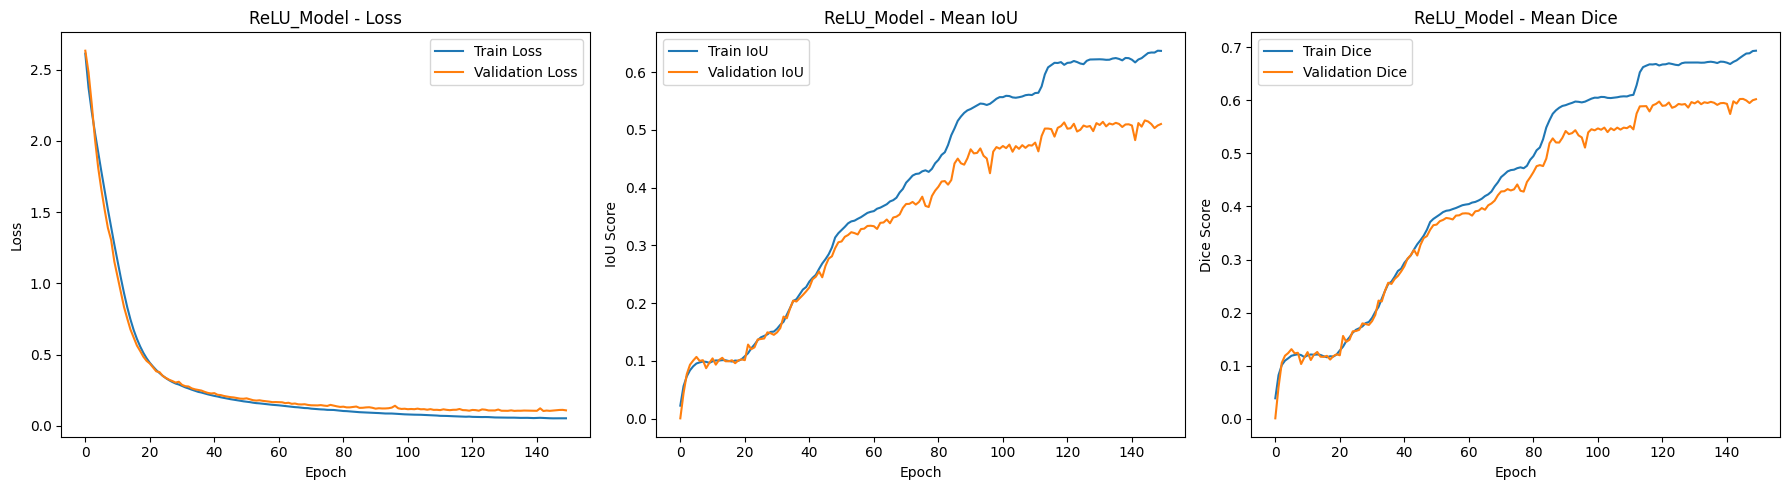

生成预测可视化...


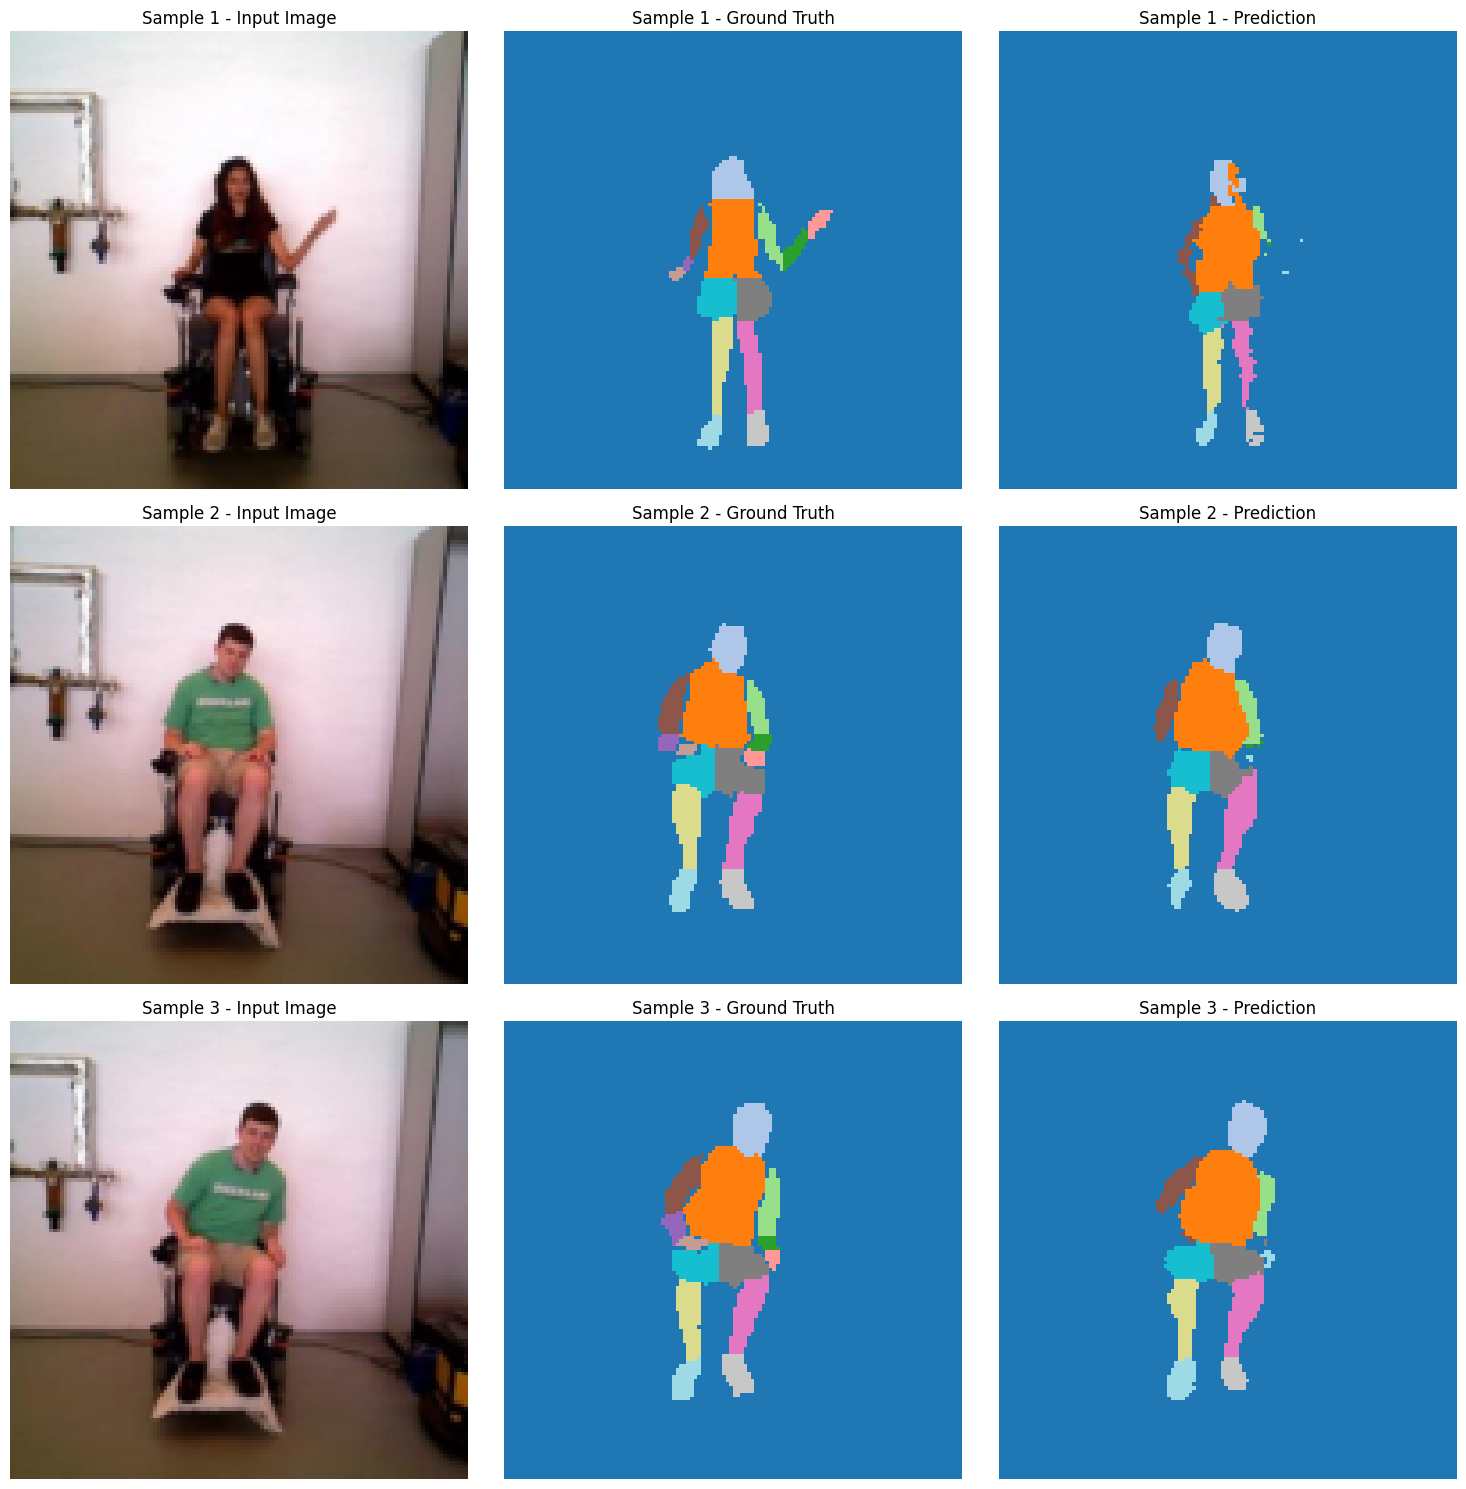

模型已保存为 'relu_model.pth'

最终结果:
训练 IoU: 0.6370
验证 IoU: 0.5103
训练 Dice: 0.6933
验证 Dice: 0.6020
训练时间: 98.41 秒


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio  # 用于读取.mat文件

class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # 获取所有图像文件名
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        # 分割训练集和测试集
        np.random.seed(42)  # 设置随机种子确保可重复性
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # 获取真实索引
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        
        # 加载图像
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # 构建对应的mat文件名
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        # 加载mat文件
        try:
            mat_data = sio.loadmat(mat_path)
            
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                for key in mat_data.keys():
                    if not key.startswith('__'):
                        mask = mat_data[key]
                        break
            
            mask = np.array(mask, dtype=np.int64)
            
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        # 应用变换
        if self.transform:
            image = self.transform(image)
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.NEAREST)
            mask = np.array(mask)
            
        mask_tensor = torch.from_numpy(mask).long()
            
        return image, mask_tensor

class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14):
        super(LightweightSegNet, self).__init__()
        
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def compute_iou(preds, labels, num_classes):
    """计算 batch 中每个类的 IoU 并取平均"""
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    if not ious:
        return 0.0
    return np.mean(ious)

def compute_dice(preds, labels, num_classes):
    """计算 batch 中每个类的 Dice 系数并取平均"""
    dices = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        dice = (2. * intersection) / (pred_inds.sum().item() + label_inds.sum().item() + 1e-8)
        if (pred_inds.sum().item() + label_inds.sum().item()) == 0:
            continue
        dices.append(dice)
    if not dices:
        return 0.0
    return np.mean(dices)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=150, device='cuda', num_classes=14):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_iou_scores = []
    val_iou_scores = []
    train_dice_scores = []
    val_dice_scores = []

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_iou = 0.0
        epoch_dice = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
            epoch_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_iou /= len(train_loader)
        epoch_dice /= len(train_loader)
        train_losses.append(epoch_loss)
        train_iou_scores.append(epoch_iou)
        train_dice_scores.append(epoch_dice)
        
        model.eval()
        val_running_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
                val_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)
        val_epoch_dice = val_dice / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_iou_scores.append(val_epoch_iou)
        val_dice_scores.append(val_epoch_dice)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Dice: {epoch_dice:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val IoU: {val_epoch_iou:.4f}, Val Dice: {val_epoch_dice:.4f}')
    
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_iou_scores': train_iou_scores,
        'val_iou_scores': val_iou_scores,
        'train_dice_scores': train_dice_scores,
        'val_dice_scores': val_dice_scores,
        'training_time': total_time
    }

def visualize_results(results, model_name):
    """可视化训练结果"""
    plt.figure(figsize=(18, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制 IoU 曲线
    plt.subplot(1, 3, 2)
    plt.plot(results['train_iou_scores'], label='Train IoU')
    plt.plot(results['val_iou_scores'], label='Validation IoU')
    plt.title(f'{model_name} - Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    
    # 绘制 Dice 曲线
    plt.subplot(1, 3, 3)
    plt.plot(results['train_dice_scores'], label='Train Dice')
    plt.plot(results['val_dice_scores'], label='Validation Dice')
    plt.title(f'{model_name} - Mean Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    """可视化模型的预测结果"""
    model.eval()
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

def inspect_mat_file(mat_path):
    """检查.mat文件的内容和结构"""
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                unique_values = np.unique(value)
                if len(unique_values) < 20:
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = r'/root/新实验/人体姿态/img'
    mask_dir = r'/root/新实验/人体姿态/masks'
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    print("检查.mat文件结构...")
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = LightweightSegNet(num_classes=num_classes)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 150
    print(f"开始训练 ReLU 模型，共 {num_epochs} 轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device,
        num_classes=num_classes
    )
    
    visualize_results(results, "ReLU_Model")
    
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    torch.save(model.state_dict(), 'relu_model.pth')
    print("模型已保存为 'relu_model.pth'")
    
    print(f"\n最终结果:")
    print(f"训练 IoU: {results['train_iou_scores'][-1]:.4f}")
    print(f"验证 IoU: {results['val_iou_scores'][-1]:.4f}")
    print(f"训练 Dice: {results['train_dice_scores'][-1]:.4f}")
    print(f"验证 Dice: {results['val_dice_scores'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f} 秒")

if __name__ == "__main__":
    main()

检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15
创建了具有15个输出类别的模型
开始训练 GELU 模型，共 150 轮...
Epoch 1/150, Train Loss: 2.3803, Train IoU: 0.0411, Train Dice: 0.0580, Val Loss: 2.4769, Val IoU: 0.0598, Val Dice: 0.0631
Epoch 2/150, Train Loss: 2.1790, Train IoU: 0.0617, Train Dice: 0.0785, Val Loss: 2.3721, Val IoU: 0.0615, Val Dice: 0.0665
Epoch 3/150, Train Loss: 2.0031, Train IoU: 0.0760, Train Dice: 0.0942, Val Loss: 2.1418, Val IoU: 0.0768, Val Dice: 0.0934
Epoch 4/150, Train Loss: 1.8459, Train IoU: 0.0848, Train Dice: 0.1039, Val Loss: 1.8729, Val IoU: 0.0898, Val Dice: 0.1099
Epoch 5/150, Train Loss: 1.7017, Train IoU: 0.0884, Train Dice: 0.1063, Val Loss: 1.5966, Val IoU: 0.0906, Val Dice: 0.1089
Epoch 6/15

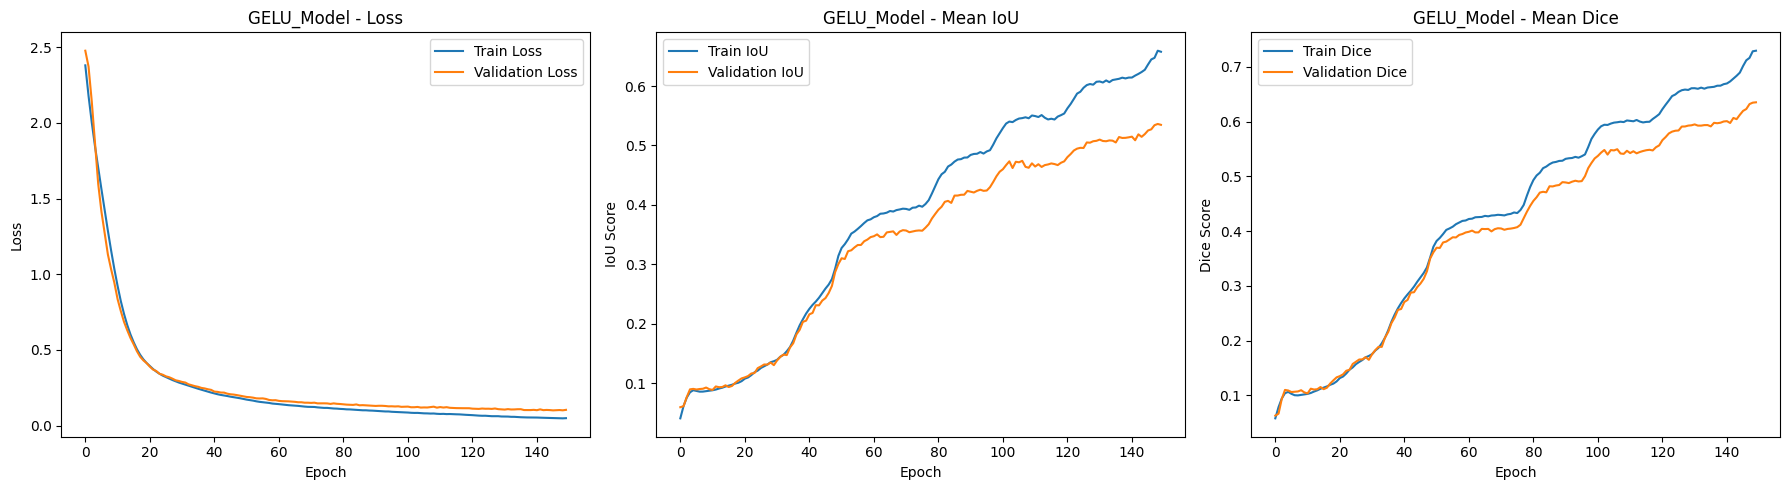

生成预测可视化...


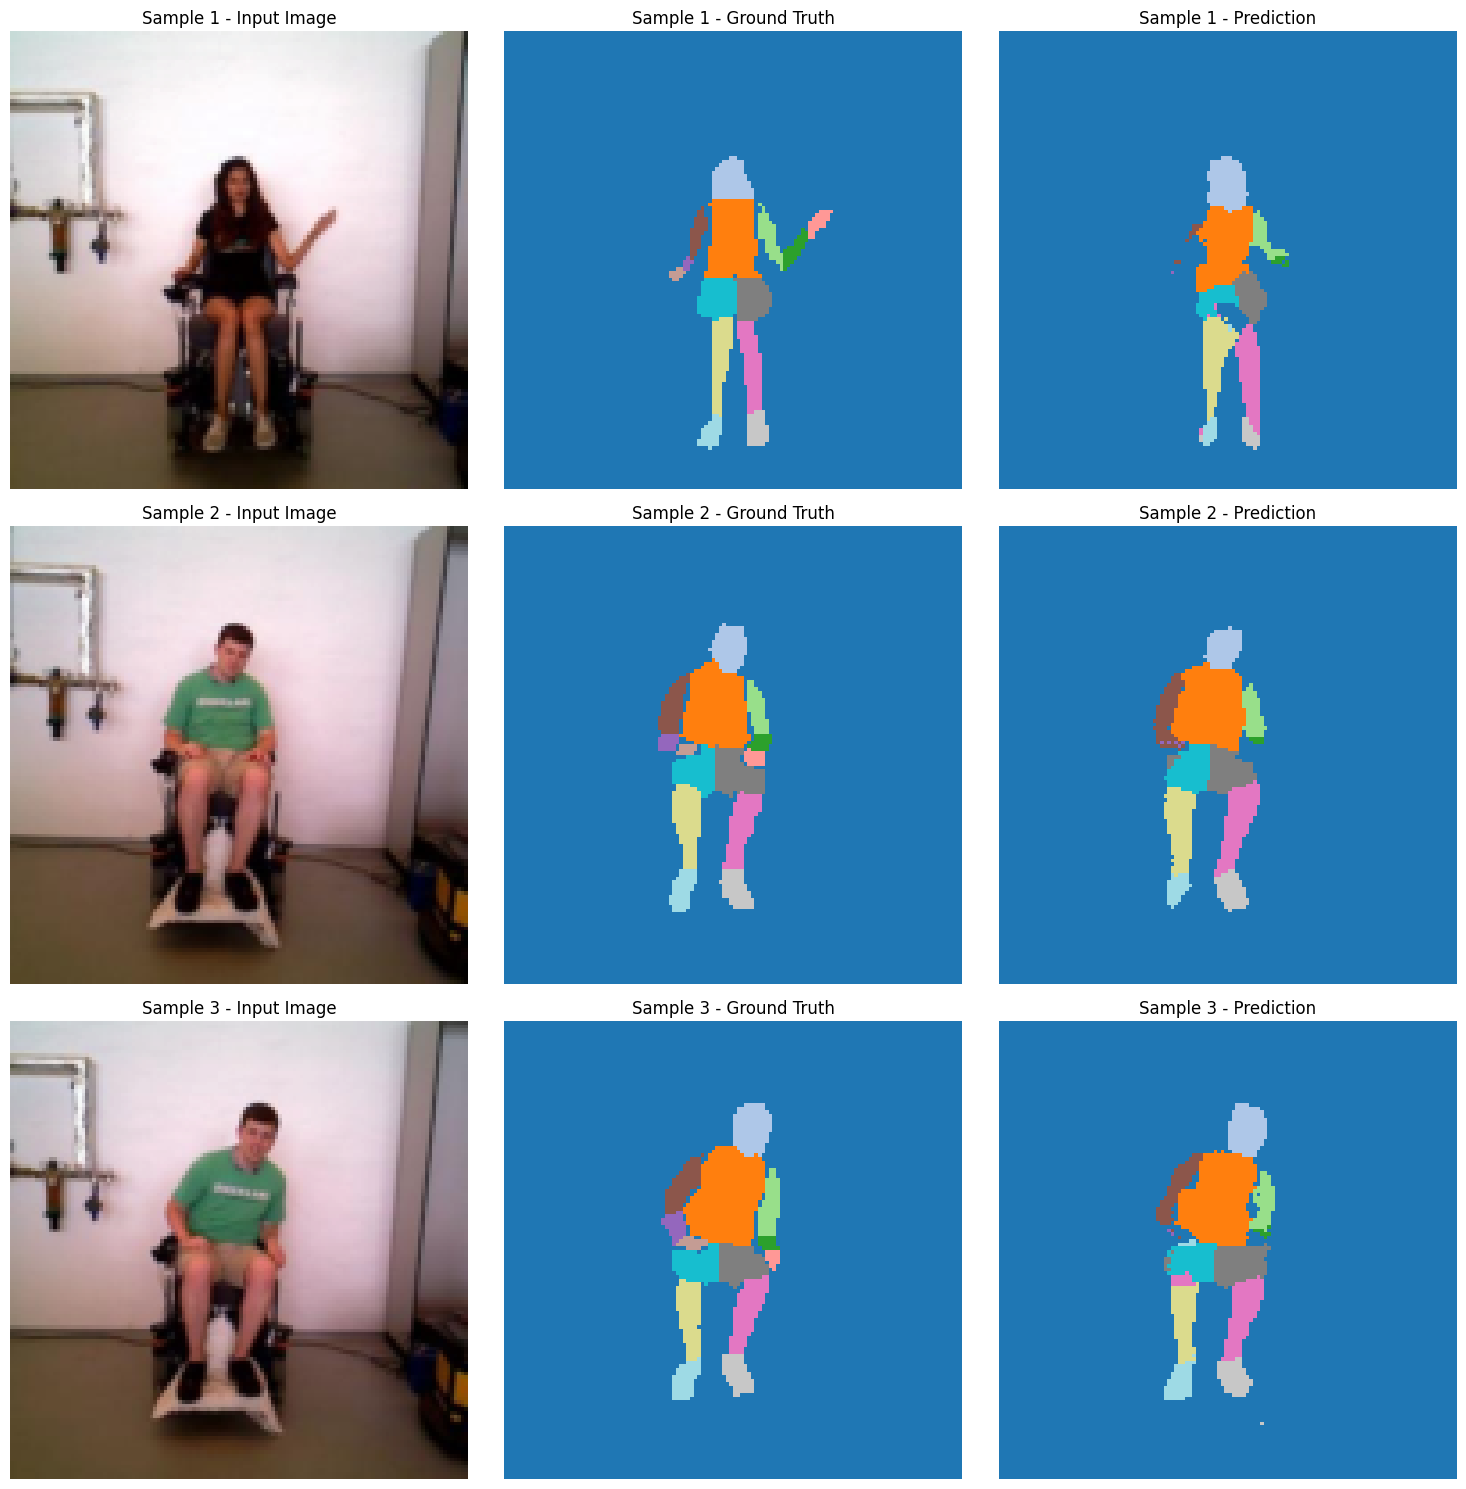

模型已保存为 'gelu_model.pth'

最终结果:
训练 IoU: 0.6576
验证 IoU: 0.5347
训练 Dice: 0.7294
验证 Dice: 0.6351
训练时间: 93.30 秒


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio  # 用于读取.mat文件


class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # 获取所有图像文件名
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        # 分割训练集和测试集
        np.random.seed(42)  # 设置随机种子确保可重复性
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # 获取真实索引
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        
        # 加载图像
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # 构建对应的mat文件名
        # 假设mat文件与图像文件同名，只是扩展名不同
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        # 加载mat文件
        try:
            mat_data = sio.loadmat(mat_path)
            
            # 提取掩码数据
            # 注意：这里需要根据实际mat文件结构调整
            # 假设mat文件中有一个名为'mask'或'segmentation'的变量
            # 您可能需要根据实际mat文件结构修改这部分
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                # 尝试获取第一个非特殊变量（通常.mat文件会包含一些元数据变量）
                for key in mat_data.keys():
                    if not key.startswith('__'):  # 跳过特殊变量如__header__
                        mask = mat_data[key]
                        break
            
            # 确保掩码是正确的形状和类型
            mask = np.array(mask, dtype=np.int64)
            
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            # 在出错的情况下提供默认掩码（全零）
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        # 应用变换
        if self.transform:
            image = self.transform(image)
            
            # 调整掩码大小与图像一致（假设为128x128）
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.Resampling.NEAREST)
            mask = np.array(mask)
            
        # 将掩码转换为torch张量
        mask_tensor = torch.from_numpy(mask).long()
            
        return image, mask_tensor

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 初值设为 1
        self.sqrt2 = torch.sqrt(torch.tensor(2.0))  # 常量提前算好（或用 register_buffer）

    def forward(self, input):
        return input / 2 * (1 + torch.erf(input / (self.sqrt2 * self.sigma)))


# 修改后的 LightweightSegNet
class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14):
        super(LightweightSegNet, self).__init__()
        
        # 单独定义每一层的 GELU 激活以跟踪不同层的 sigma
        self.gelu1 = GELU()
        self.gelu2 = GELU()
        self.gelu3 = GELU()
        self.gelu4 = GELU()
        self.gelu5 = GELU()
        self.gelu6 = GELU()

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            self.gelu1,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.gelu2,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.gelu3,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            self.gelu4,

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            self.gelu5,

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(16),
            self.gelu6,

            nn.Conv2d(16, num_classes, kernel_size=1)  # 输出层
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def compute_iou(preds, labels, num_classes):
    """计算 batch 中每个类的 IoU 并取平均"""
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            continue  # 避免除0
        ious.append(intersection / union)
    if not ious:
        return 0.0
    return np.mean(ious)

def compute_dice(preds, labels, num_classes):
    """计算 batch 中每个类的 Dice 系数并取平均"""
    dices = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        dice = (2. * intersection) / (pred_inds.sum().item() + label_inds.sum().item() + 1e-8)
        if (pred_inds.sum().item() + label_inds.sum().item()) == 0:
            continue
        dices.append(dice)
    if not dices:
        return 0.0
    return np.mean(dices)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', num_classes=14):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_iou_scores = []
    val_iou_scores = []
    train_dice_scores = []
    val_dice_scores = []

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_iou = 0.0
        epoch_dice = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
            epoch_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_iou /= len(train_loader)
        epoch_dice /= len(train_loader)
        train_losses.append(epoch_loss)
        train_iou_scores.append(epoch_iou)
        train_dice_scores.append(epoch_dice)
        
        model.eval()
        val_running_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
                val_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)
        val_epoch_dice = val_dice / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_iou_scores.append(val_epoch_iou)
        val_dice_scores.append(val_epoch_dice)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Dice: {epoch_dice:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val IoU: {val_epoch_iou:.4f}, Val Dice: {val_epoch_dice:.4f}')
    
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_iou_scores': train_iou_scores,
        'val_iou_scores': val_iou_scores,
        'train_dice_scores': train_dice_scores,
        'val_dice_scores': val_dice_scores,
        'training_time': total_time
    }

def visualize_results(results, model_name):
    """可视化训练结果"""
    plt.figure(figsize=(18, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制 IoU 曲线
    plt.subplot(1, 3, 2)
    plt.plot(results['train_iou_scores'], label='Train IoU')
    plt.plot(results['val_iou_scores'], label='Validation IoU')
    plt.title(f'{model_name} - Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    
    # 绘制 Dice 曲线
    plt.subplot(1, 3, 3)
    plt.plot(results['train_dice_scores'], label='Train Dice')
    plt.plot(results['val_dice_scores'], label='Validation Dice')
    plt.title(f'{model_name} - Mean Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    """可视化模型的预测结果"""
    model.eval()
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # 转回CPU进行可视化
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            # 反标准化图像
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            # 绘制原图、真实标签和预测标签
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

def inspect_mat_file(mat_path):
    """检查.mat文件的内容和结构"""
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):  # 跳过特殊变量
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                # 打印唯一值，查看是否是分类标签
                unique_values = np.unique(value)
                if len(unique_values) < 20:  # 如果唯一值数量较少，可能是类别标签
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = r'/root/新实验/人体姿态/img'
    mask_dir = r'/root/新实验/人体姿态/masks'
    
    # 检查目录是否存在
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    # 首先检查一个.mat文件，了解其结构
    print("检查.mat文件结构...")
    # 查找第一个.mat文件
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 数据变换
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 创建数据集
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    # 检查数据集大小
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    # 检查第一个样本
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    # 确定类别数量 (14个部分 + 背景类)
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    # 创建数据加载器
    batch_size = 16  # 小批量以减少内存使用
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # 创建模型
    model = LightweightSegNet(num_classes=num_classes)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练模型
    num_epochs = 150  # 减少训练轮次以加快训练
    print(f"开始训练 GELU 模型，共 {num_epochs} 轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device,
        num_classes=num_classes
    )
    
    # 可视化训练结果
    visualize_results(results, "GELU_Model")
    
    # 可视化一些预测结果
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    # 保存模型
    torch.save(model.state_dict(), 'gelu_model.pth')
    print("模型已保存为 'gelu_model.pth'")
    
    # 输出最终结果
    print(f"\n最终结果:")
    print(f"训练 IoU: {results['train_iou_scores'][-1]:.4f}")
    print(f"验证 IoU: {results['val_iou_scores'][-1]:.4f}")
    print(f"训练 Dice: {results['train_dice_scores'][-1]:.4f}")
    print(f"验证 Dice: {results['val_dice_scores'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f} 秒")

if __name__ == "__main__":
    main()

[I 2025-04-20 22:36:26,575] A new study created in memory with name: no-name-43e5125a-6cb7-441d-8507-fedaf4fd2e56


检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15

开始Optuna优化各GELU层的独立sigma参数...


[I 2025-04-20 22:37:59,467] Trial 0 finished with value: 0.5986365562688277 and parameters: {'sigma_0': 2.406534755762585, 'sigma_1': 1.6769226209060946, 'sigma_2': 1.44057820572454, 'sigma_3': 3.477833185463913, 'sigma_4': 2.309071172938553, 'sigma_5': 2.614501112150754}. Best is trial 0 with value: 0.5986365562688277.
[I 2025-04-20 22:39:29,762] Trial 1 finished with value: 0.5940379249413822 and parameters: {'sigma_0': 4.025608516235482, 'sigma_1': 4.565258920871215, 'sigma_2': 2.589979649570108, 'sigma_3': 2.2904525543230605, 'sigma_4': 3.4822306434332555, 'sigma_5': 2.581103033569917}. Best is trial 0 with value: 0.5986365562688277.
[I 2025-04-20 22:40:59,294] Trial 2 finished with value: 0.6058594485650549 and parameters: {'sigma_0': 1.491840311754138, 'sigma_1': 1.5718612953666349, 'sigma_2': 4.410482383870956, 'sigma_3': 4.336641483115764, 'sigma_4': 2.2993899405478353, 'sigma_5': 5.414065465440392}. Best is trial 2 with value: 0.6058594485650549.
[I 2025-04-20 22:42:28,250] Tr


最佳试验结果:
  最佳验证IoU: 0.6059
  最佳sigma参数:
    GELU_1: 1.4918
    GELU_2: 1.5719
    GELU_3: 4.4105
    GELU_4: 4.3366
    GELU_5: 2.2994
    GELU_6: 5.4141

使用最佳sigma参数重新训练模型: [1.491840311754138, 1.5718612953666349, 4.410482383870956, 4.336641483115764, 2.2993899405478353, 5.414065465440392]
创建了具有15个输出类别的模型
开始训练优化后的GELU模型，共150轮...
Epoch 1/150, Train Loss: 2.5827, Train IoU: 0.0283, Train Dice: 0.0454, Val Loss: 2.5832, Val IoU: 0.0017, Val Dice: 0.0033
Epoch 2/150, Train Loss: 2.4531, Train IoU: 0.0624, Train Dice: 0.0831, Val Loss: 2.4060, Val IoU: 0.0715, Val Dice: 0.0813
Epoch 3/150, Train Loss: 2.3564, Train IoU: 0.0749, Train Dice: 0.0972, Val Loss: 2.2172, Val IoU: 0.0859, Val Dice: 0.1023
Epoch 4/150, Train Loss: 2.2606, Train IoU: 0.0888, Train Dice: 0.1168, Val Loss: 2.1278, Val IoU: 0.0992, Val Dice: 0.1273
Epoch 5/150, Train Loss: 2.1657, Train IoU: 0.1010, Train Dice: 0.1336, Val Loss: 2.0250, Val IoU: 0.1092, Val Dice: 0.1432
Epoch 6/150, Train Loss: 2.0727, Train IoU: 0.104

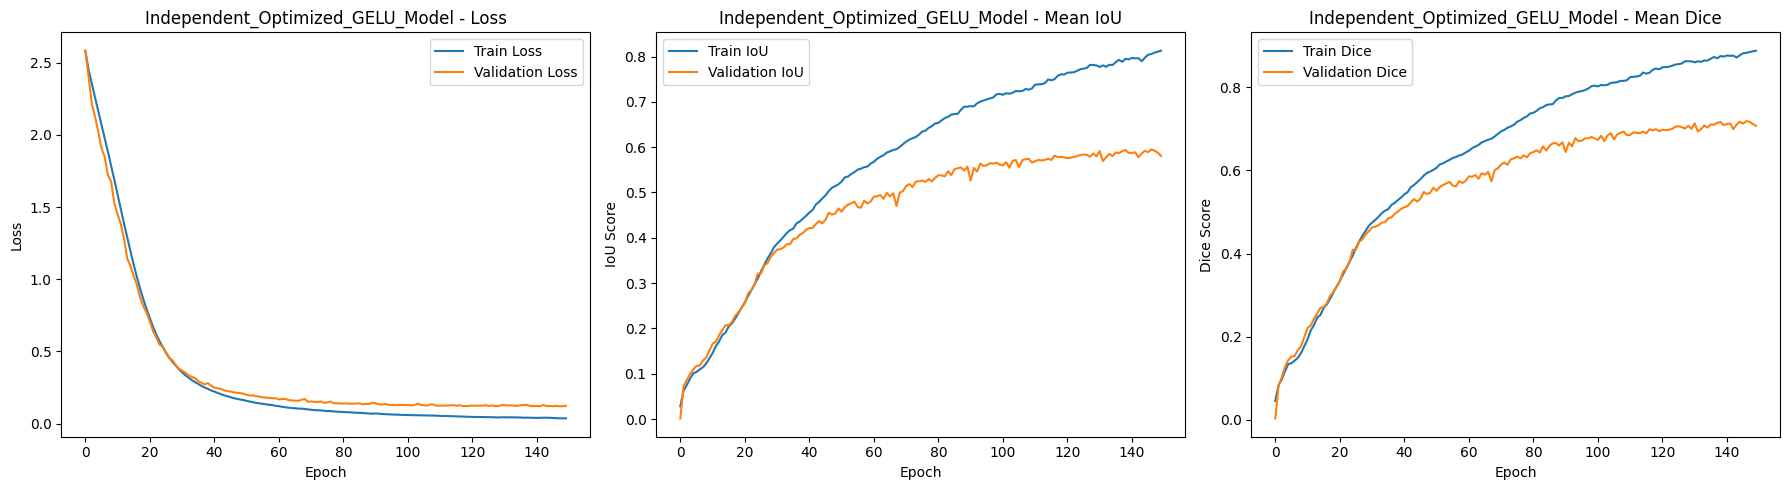

生成预测可视化...


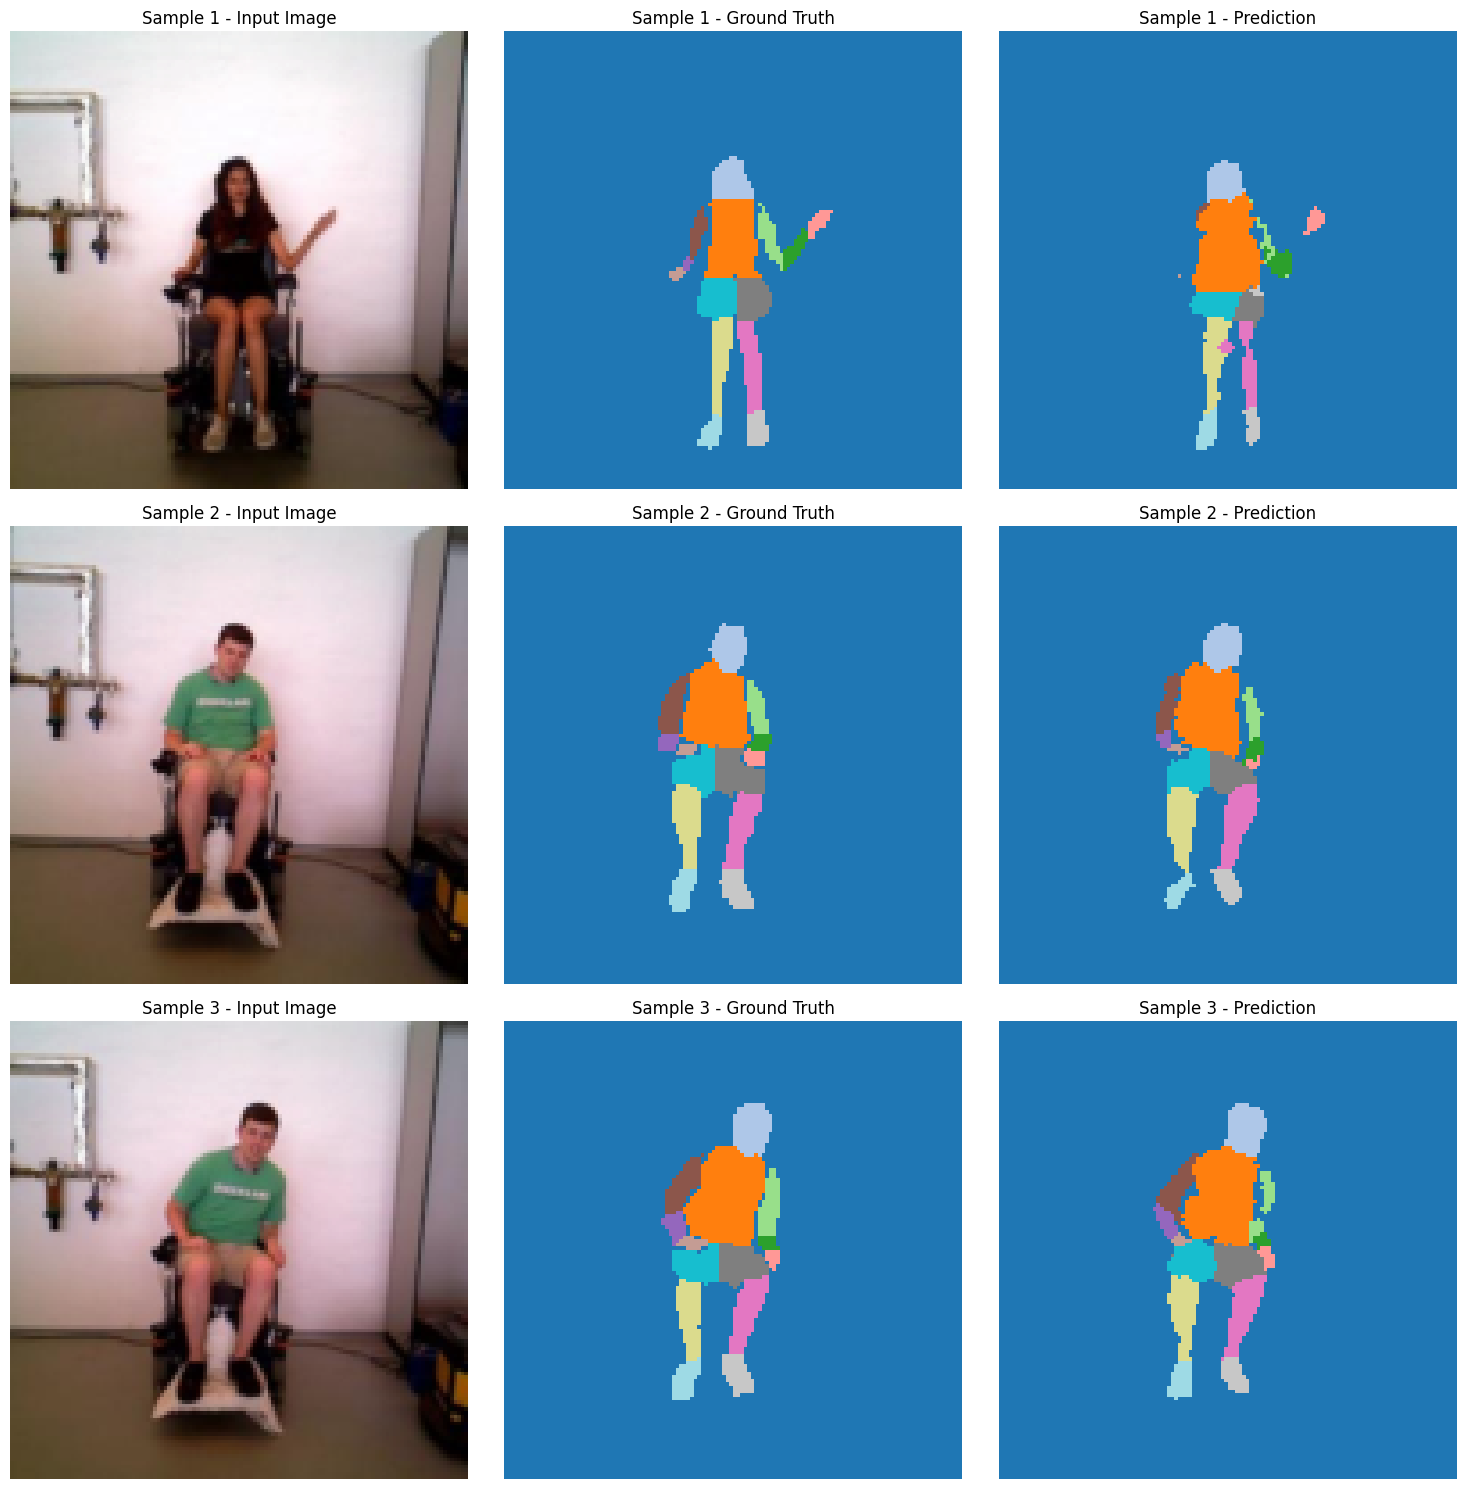

模型已保存为 'independent_optimized_gelu_model.pth'

最终结果:
训练IoU: 0.8128
验证IoU: 0.5807
训练Dice: 0.8880
验证Dice: 0.7073
训练时间: 94.68秒


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio
import optuna
from optuna.trial import TrialState

# 数据集类
class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        np.random.seed(42)
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        try:
            mat_data = sio.loadmat(mat_path)
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                for key in mat_data.keys():
                    if not key.startswith('__'):
                        mask = mat_data[key]
                        break
            
            mask = np.array(mask, dtype=np.int64)
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        if self.transform:
            image = self.transform(image)
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.NEAREST)
            mask = np.array(mask)
            
        mask_tensor = torch.from_numpy(mask).long()
        return image, mask_tensor


class GELU(nn.Module):
    def __init__(self, sigma_init=2.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))
        self.sqrt2 = torch.sqrt(torch.tensor(2.0))

    def forward(self, input):
        return input / 2 * (1 + torch.erf(input / (self.sqrt2 * self.sigma)))

# 轻量级分割网络
class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14, sigma_inits=None):
        super(LightweightSegNet, self).__init__()
        
        # 默认sigma初始值
        default_sigmas = [4.4, 5.6, 2.0, 1.7, 2.3, 3.8]
        if sigma_inits is not None:
            default_sigmas = sigma_inits
            
        # 每个GELU层使用独立的sigma参数
        self.gelu1 = GELU(sigma_init=default_sigmas[0])
        self.gelu2 = GELU(sigma_init=default_sigmas[1])
        self.gelu3 = GELU(sigma_init=default_sigmas[2])
        self.gelu4 = GELU(sigma_init=default_sigmas[3])
        self.gelu5 = GELU(sigma_init=default_sigmas[4])
        self.gelu6 = GELU(sigma_init=default_sigmas[5])

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            self.gelu1,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.gelu2,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.gelu3,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            self.gelu4,

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            self.gelu5,

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(16),
            self.gelu6,

            nn.Conv2d(16, num_classes, kernel_size=1)  # 输出层
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_sigma_values(self):
        """获取当前所有GELU层的sigma参数值"""
        return [
            self.gelu1.sigma.item(),
            self.gelu2.sigma.item(),
            self.gelu3.sigma.item(),
            self.gelu4.sigma.item(),
            self.gelu5.sigma.item(),
            self.gelu6.sigma.item()
        ]


# 评估指标计算
def compute_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0.0

def compute_dice(preds, labels, num_classes):
    dices = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        dice = (2. * intersection) / (pred_inds.sum().item() + label_inds.sum().item() + 1e-8)
        if (pred_inds.sum().item() + label_inds.sum().item()) == 0:
            continue
        dices.append(dice)
    return np.mean(dices) if dices else 0.0

# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', num_classes=14):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_iou_scores = []
    val_iou_scores = []
    train_dice_scores = []
    val_dice_scores = []

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_iou = 0.0
        epoch_dice = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
            epoch_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_iou /= len(train_loader)
        epoch_dice /= len(train_loader)
        train_losses.append(epoch_loss)
        train_iou_scores.append(epoch_iou)
        train_dice_scores.append(epoch_dice)
        
        model.eval()
        val_running_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
                val_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)
        val_epoch_dice = val_dice / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_iou_scores.append(val_epoch_iou)
        val_dice_scores.append(val_epoch_dice)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Dice: {epoch_dice:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val IoU: {val_epoch_iou:.4f}, Val Dice: {val_epoch_dice:.4f}')
    
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_iou_scores': train_iou_scores,
        'val_iou_scores': val_iou_scores,
        'train_dice_scores': train_dice_scores,
        'val_dice_scores': val_dice_scores,
        'training_time': total_time
    }

# Optuna优化目标函数（独立优化每个GELU的sigma）
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 为每个GELU层建议独立的sigma初始值
    sigma_inits = [
        trial.suggest_float(f'sigma_{i}', 0.1, 6.0) for i in range(6)
    ]
    
    model = LightweightSegNet(num_classes=num_classes, sigma_inits=sigma_inits).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_iou = 0.0
    for epoch in range(150):  # 每个trial训练150次
        model.train()
        epoch_iou = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
        
        epoch_iou /= len(train_loader)
        
        # 验证
        model.eval()
        val_iou = 0.0
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
        
        val_iou /= len(val_loader)
        
        # 报告中间结果给Optuna
        trial.report(val_iou, epoch)
        
        # 如果试验被剪枝则提前终止
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        if val_iou > best_iou:
            best_iou = val_iou
    
    return best_iou

# 可视化函数
def visualize_results(results, model_name):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(results['train_iou_scores'], label='Train IoU')
    plt.plot(results['val_iou_scores'], label='Validation IoU')
    plt.title(f'{model_name} - Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(results['train_dice_scores'], label='Train Dice')
    plt.plot(results['val_dice_scores'], label='Validation Dice')
    plt.title(f'{model_name} - Mean Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

def inspect_mat_file(mat_path):
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                unique_values = np.unique(value)
                if len(unique_values) < 20:
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = r'/root/新实验/人体姿态/img'
    mask_dir = r'/root/新实验/人体姿态/masks'
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    print("检查.mat文件结构...")
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    global num_classes  # 定义为全局变量供objective函数使用
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    global train_loader, val_loader  # 定义为全局变量供objective函数使用
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Optuna优化
    print("\n开始Optuna优化各GELU层的独立sigma参数...")
    study = optuna.create_study(
        direction='maximize',
    )
    
    # 运行5个trials，每个trial训练150个epoch
    study.optimize(objective, n_trials=5, timeout=None)
    
    print("\n最佳试验结果:")
    trial = study.best_trial
    print(f"  最佳验证IoU: {trial.value:.4f}")
    print("  最佳sigma参数:")
    for i in range(6):
        print(f"    GELU_{i+1}: {trial.params[f'sigma_{i}']:.4f}")
    
    # 使用最佳参数重新训练模型
    best_sigmas = [trial.params[f'sigma_{i}'] for i in range(6)]
    print(f"\n使用最佳sigma参数重新训练模型: {best_sigmas}")
    
    model = LightweightSegNet(num_classes=num_classes, sigma_inits=best_sigmas)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 150
    print(f"开始训练优化后的GELU模型，共{num_epochs}轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device,
        num_classes=num_classes
    )
    
    # 打印最终学习到的sigma值
    final_sigmas = model.get_sigma_values()
    print("\n训练后各GELU层的sigma参数值:")
    for i, sigma in enumerate(final_sigmas):
        print(f"  GELU_{i+1}: {sigma:.4f} (初始: {best_sigmas[i]:.4f})")
    
    visualize_results(results, "Independent_Optimized_GELU_Model")
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    torch.save(model.state_dict(), 'independent_optimized_gelu_model.pth')
    print("模型已保存为 'independent_optimized_gelu_model.pth'")
    
    print(f"\n最终结果:")
    print(f"训练IoU: {results['train_iou_scores'][-1]:.4f}")
    print(f"验证IoU: {results['val_iou_scores'][-1]:.4f}")
    print(f"训练Dice: {results['train_dice_scores'][-1]:.4f}")
    print(f"验证Dice: {results['val_dice_scores'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f}秒")

if __name__ == "__main__":
    main()

[I 2025-04-20 22:51:11,943] A new study created in memory with name: no-name-954114f7-6938-4ef8-b12c-c9bdca2e80bb


检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15

开始Optuna优化各ExLU层的独立sigma参数...


[I 2025-04-20 22:52:43,542] Trial 0 finished with value: 0.5606132483437732 and parameters: {'sigma_0': 1.073953674123301, 'sigma_1': 1.090018772067937, 'sigma_2': 0.5801366285484364, 'sigma_3': 1.3095142445230759, 'sigma_4': 1.7826909723746036, 'sigma_5': 0.7566785382124759}. Best is trial 0 with value: 0.5606132483437732.
[I 2025-04-20 22:54:11,254] Trial 1 finished with value: 0.33538582600039835 and parameters: {'sigma_0': 0.2265081434150799, 'sigma_1': 1.2173696202087243, 'sigma_2': 1.1302812380207377, 'sigma_3': 0.3667163007472294, 'sigma_4': 1.5430376775287347, 'sigma_5': 1.6212512685635865}. Best is trial 0 with value: 0.5606132483437732.
[I 2025-04-20 22:55:44,010] Trial 2 finished with value: 0.5585484445755132 and parameters: {'sigma_0': 1.5235582536442234, 'sigma_1': 0.7146610083127847, 'sigma_2': 1.2971638163190093, 'sigma_3': 0.4862074339250939, 'sigma_4': 1.5246862813339848, 'sigma_5': 1.3442984224916699}. Best is trial 0 with value: 0.5606132483437732.
[I 2025-04-20 22:


最佳试验结果:
  最佳验证IoU: 0.5797
  最佳sigma参数:
    ExLU_1: 1.9426
    ExLU_2: 1.0960
    ExLU_3: 1.8394
    ExLU_4: 1.3363
    ExLU_5: 1.8678
    ExLU_6: 1.2199

使用最佳sigma参数重新训练模型: [1.9426024672608138, 1.0960373476829157, 1.8394438722268454, 1.3363355927680503, 1.8678285470821123, 1.2198692641998112]
创建了具有15个输出类别的模型
开始训练优化后的ExLU模型，共150轮...
Epoch 1/150, Train Loss: 2.6491, Train IoU: 0.0318, Train Dice: 0.0503, Val Loss: 2.5843, Val IoU: 0.0177, Val Dice: 0.0312
Epoch 2/150, Train Loss: 2.3409, Train IoU: 0.0662, Train Dice: 0.0865, Val Loss: 2.1597, Val IoU: 0.0735, Val Dice: 0.0888
Epoch 3/150, Train Loss: 2.1527, Train IoU: 0.0705, Train Dice: 0.0879, Val Loss: 1.7423, Val IoU: 0.0758, Val Dice: 0.0892
Epoch 4/150, Train Loss: 1.9972, Train IoU: 0.0793, Train Dice: 0.0990, Val Loss: 1.6214, Val IoU: 0.0869, Val Dice: 0.1068
Epoch 5/150, Train Loss: 1.8618, Train IoU: 0.0839, Train Dice: 0.1035, Val Loss: 1.6172, Val IoU: 0.0858, Val Dice: 0.1040
Epoch 6/150, Train Loss: 1.7311, Train IoU: 0

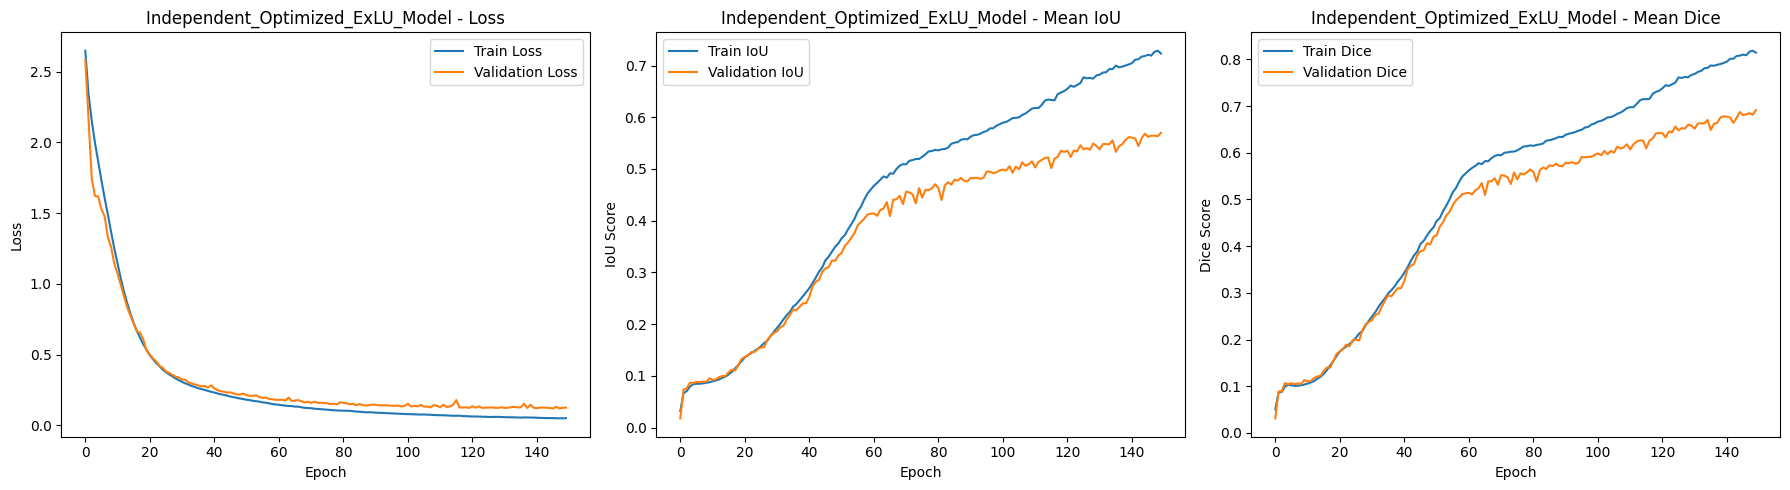

生成预测可视化...


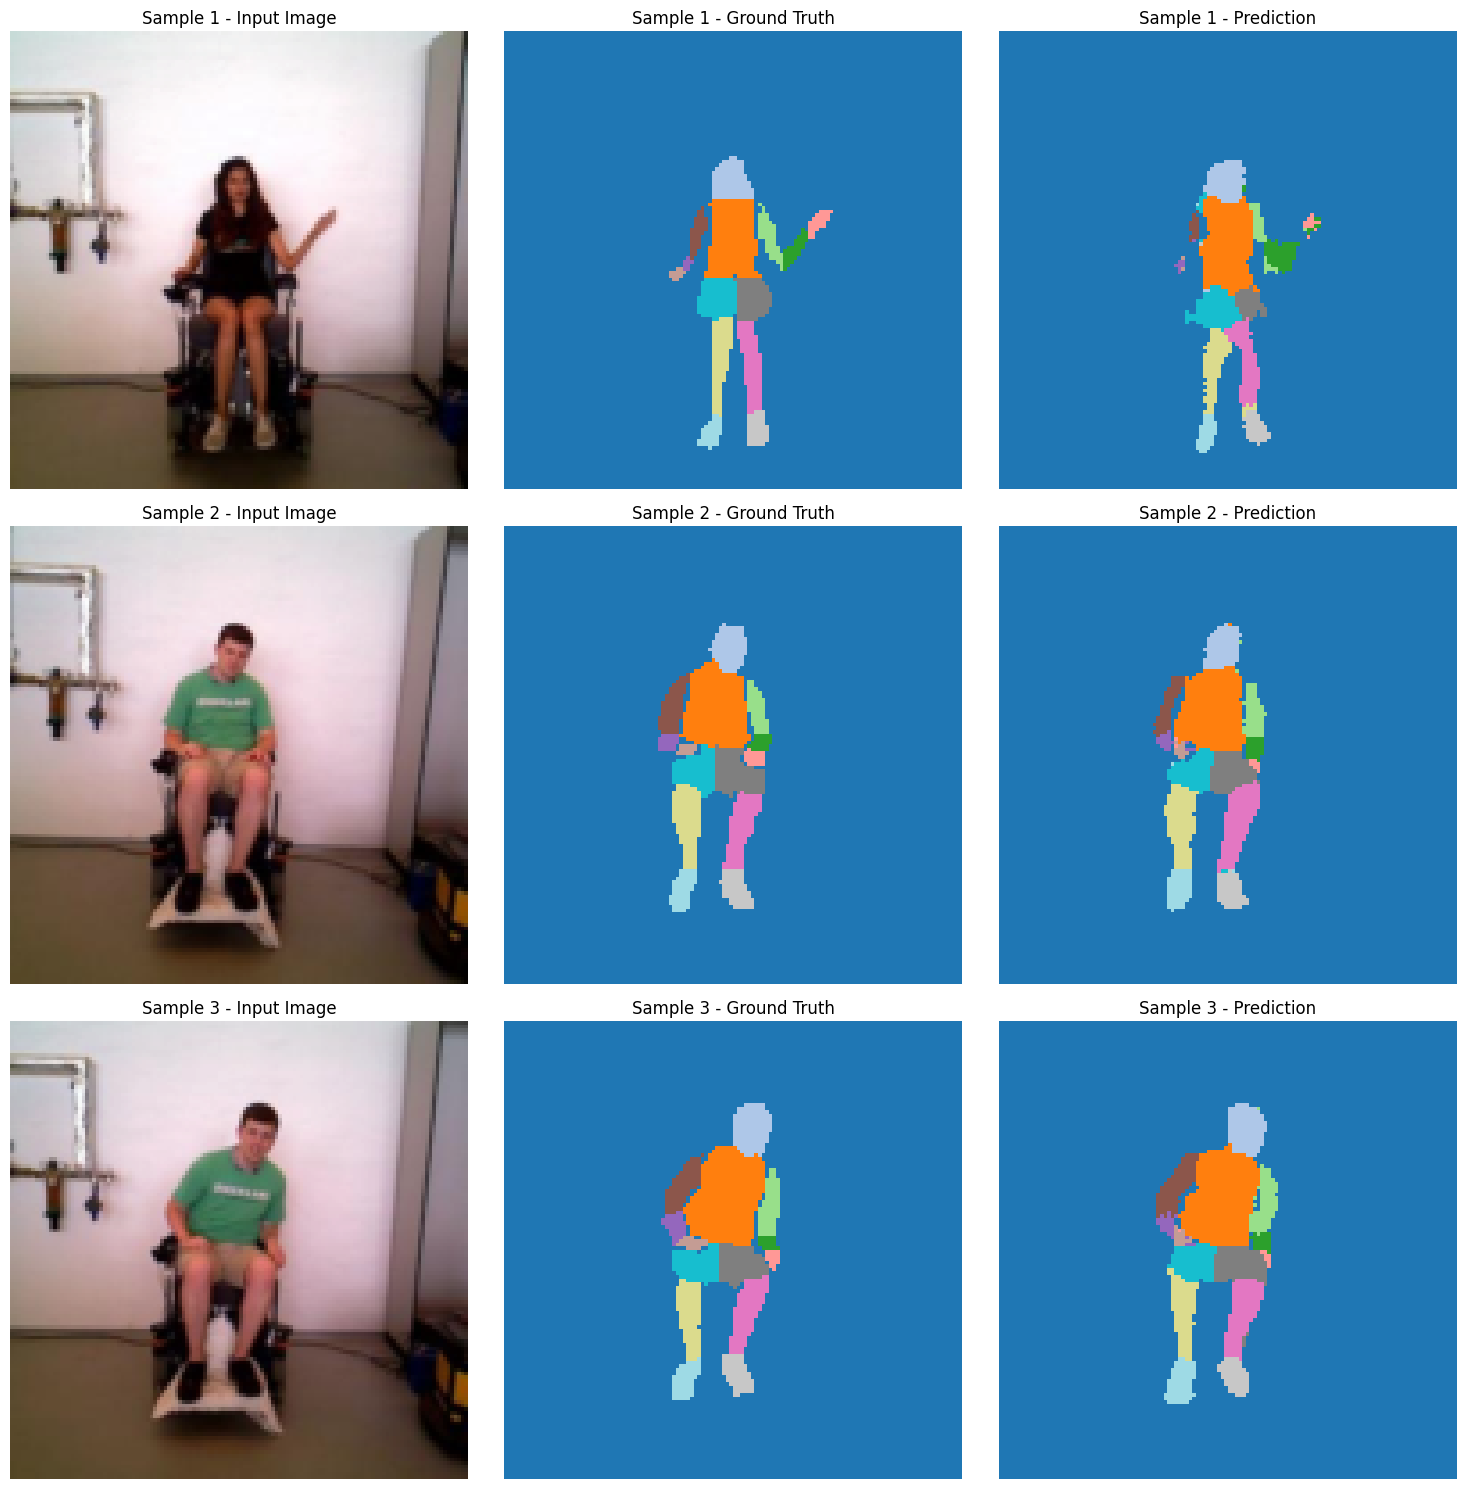

模型已保存为 'independent_optimized_exlu_model.pth'

最终结果:
训练IoU: 0.7231
验证IoU: 0.5698
训练Dice: 0.8143
验证Dice: 0.6912
训练时间: 92.34秒


In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio
import optuna
from optuna.trial import TrialState

# 数据集类
class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        np.random.seed(42)
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        try:
            mat_data = sio.loadmat(mat_path)
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                for key in mat_data.keys():
                    if not key.startswith('__'):
                        mask = mat_data[key]
                        break
            
            mask = np.array(mask, dtype=np.int64)
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        if self.transform:
            image = self.transform(image)
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.NEAREST)
            mask = np.array(mask)
            
        mask_tensor = torch.from_numpy(mask).long()
        return image, mask_tensor

# 定义ExLU激活函数
class ExLU(nn.Module):
    def __init__(self, sigma=1.0):
        super(ExLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))
    
    def forward(self, x):
        return torch.where(x >= 0, x, x * torch.exp(x / self.sigma))

# 轻量级分割网络
class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14, sigma_inits=None):
        super(LightweightSegNet, self).__init__()
        
        # 默认sigma初始值
        default_sigmas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # ExLU通常初始sigma设为1.0
        if sigma_inits is not None:
            default_sigmas = sigma_inits
            
        # 每个ExLU层使用独立的sigma参数
        self.exlu1 = ExLU(sigma=default_sigmas[0])
        self.exlu2 = ExLU(sigma=default_sigmas[1])
        self.exlu3 = ExLU(sigma=default_sigmas[2])
        self.exlu4 = ExLU(sigma=default_sigmas[3])
        self.exlu5 = ExLU(sigma=default_sigmas[4])
        self.exlu6 = ExLU(sigma=default_sigmas[5])

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            self.exlu1,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.exlu2,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.exlu3,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            self.exlu4,

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            self.exlu5,

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(16),
            self.exlu6,

            nn.Conv2d(16, num_classes, kernel_size=1)  # 输出层
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_sigma_values(self):
        """获取当前所有ExLU层的sigma参数值"""
        return [
            self.exlu1.sigma.item(),
            self.exlu2.sigma.item(),
            self.exlu3.sigma.item(),
            self.exlu4.sigma.item(),
            self.exlu5.sigma.item(),
            self.exlu6.sigma.item()
        ]

# 评估指标计算
def compute_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0.0

def compute_dice(preds, labels, num_classes):
    dices = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        dice = (2. * intersection) / (pred_inds.sum().item() + label_inds.sum().item() + 1e-8)
        if (pred_inds.sum().item() + label_inds.sum().item()) == 0:
            continue
        dices.append(dice)
    return np.mean(dices) if dices else 0.0

# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', num_classes=14):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_iou_scores = []
    val_iou_scores = []
    train_dice_scores = []
    val_dice_scores = []

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_iou = 0.0
        epoch_dice = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
            epoch_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_iou /= len(train_loader)
        epoch_dice /= len(train_loader)
        train_losses.append(epoch_loss)
        train_iou_scores.append(epoch_iou)
        train_dice_scores.append(epoch_dice)
        
        model.eval()
        val_running_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
                val_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)
        val_epoch_dice = val_dice / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_iou_scores.append(val_epoch_iou)
        val_dice_scores.append(val_epoch_dice)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Dice: {epoch_dice:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val IoU: {val_epoch_iou:.4f}, Val Dice: {val_epoch_dice:.4f}')
    
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_iou_scores': train_iou_scores,
        'val_iou_scores': val_iou_scores,
        'train_dice_scores': train_dice_scores,
        'val_dice_scores': val_dice_scores,
        'training_time': total_time
    }

# Optuna优化目标函数（独立优化每个ExLU的sigma）
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 为每个ExLU层建议独立的sigma初始值
    sigma_inits = [
        trial.suggest_float(f'sigma_{i}', 0.1, 2.0) for i in range(6)
    ]
    
    model = LightweightSegNet(num_classes=num_classes, sigma_inits=sigma_inits).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_iou = 0.0
    for epoch in range(150):  # 每个trial训练150次
        model.train()
        epoch_iou = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
        
        epoch_iou /= len(train_loader)
        
        # 验证
        model.eval()
        val_iou = 0.0
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
        
        val_iou /= len(val_loader)
        
        # 报告中间结果给Optuna
        trial.report(val_iou, epoch)
        
        # 如果试验被剪枝则提前终止
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        if val_iou > best_iou:
            best_iou = val_iou
    
    return best_iou

# 可视化函数
def visualize_results(results, model_name):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(results['train_iou_scores'], label='Train IoU')
    plt.plot(results['val_iou_scores'], label='Validation IoU')
    plt.title(f'{model_name} - Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(results['train_dice_scores'], label='Train Dice')
    plt.plot(results['val_dice_scores'], label='Validation Dice')
    plt.title(f'{model_name} - Mean Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('ExLU-loss图.png')
    plt.show()

def inspect_mat_file(mat_path):
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                unique_values = np.unique(value)
                if len(unique_values) < 20:
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = r'/root/新实验/人体姿态/img'
    mask_dir = r'/root/新实验/人体姿态/masks'
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    print("检查.mat文件结构...")
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    global num_classes  # 定义为全局变量供objective函数使用
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    global train_loader, val_loader  # 定义为全局变量供objective函数使用
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Optuna优化
    print("\n开始Optuna优化各ExLU层的独立sigma参数...")
    study = optuna.create_study(
        direction='maximize',
    )
    
    # 运行5个trials，每个trial训练150个epoch
    study.optimize(objective, n_trials=5, timeout=None)
    
    print("\n最佳试验结果:")
    trial = study.best_trial
    print(f"  最佳验证IoU: {trial.value:.4f}")
    print("  最佳sigma参数:")
    for i in range(6):
        print(f"    ExLU_{i+1}: {trial.params[f'sigma_{i}']:.4f}")
    
    # 使用最佳参数重新训练模型
    best_sigmas = [trial.params[f'sigma_{i}'] for i in range(6)]
    print(f"\n使用最佳sigma参数重新训练模型: {best_sigmas}")
    
    model = LightweightSegNet(num_classes=num_classes, sigma_inits=best_sigmas)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 150
    print(f"开始训练优化后的ExLU模型，共{num_epochs}轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device,
        num_classes=num_classes
    )
    
    # 打印最终学习到的sigma值
    final_sigmas = model.get_sigma_values()
    print("\n训练后各ExLU层的sigma参数值:")
    for i, sigma in enumerate(final_sigmas):
        print(f"  ExLU_{i+1}: {sigma:.4f} (初始: {best_sigmas[i]:.4f})")
    
    visualize_results(results, "Independent_Optimized_ExLU_Model")
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    torch.save(model.state_dict(), 'independent_optimized_exlu_model.pth')
    print("模型已保存为 'independent_optimized_exlu_model.pth'")
    
    print(f"\n最终结果:")
    print(f"训练IoU: {results['train_iou_scores'][-1]:.4f}")
    print(f"验证IoU: {results['val_iou_scores'][-1]:.4f}")
    print(f"训练Dice: {results['train_dice_scores'][-1]:.4f}")
    print(f"验证Dice: {results['val_dice_scores'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f}秒")

if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio
import optuna
from optuna.trial import TrialState

# 数据集类
class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        np.random.seed(42)
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        try:
            mat_data = sio.loadmat(mat_path)
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                for key in mat_data.keys():
                    if not key.startswith('__'):
                        mask = mat_data[key]
                        break
            
            mask = np.array(mask, dtype=np.int64)
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        if self.transform:
            image = self.transform(image)
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.NEAREST)
            mask = np.array(mask)
            
        mask_tensor = torch.from_numpy(mask).long()
        return image, mask_tensor

# 定义ExLU激活函数
class ExLU(nn.Module):
    def __init__(self, sigma=1.0):
        super(ExLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))
    
    def forward(self, x):
        return torch.where(x >= 0, x, x * torch.exp(x / self.sigma))

# 轻量级分割网络
class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14, sigma_inits=None):
        super(LightweightSegNet, self).__init__()
        
        # 默认sigma初始值
        default_sigmas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # ExLU通常初始sigma设为1.0
        if sigma_inits is not None:
            default_sigmas = sigma_inits
            
        # 每个ExLU层使用独立的sigma参数
        self.exlu1 = ExLU(sigma=default_sigmas[0])
        self.exlu2 = ExLU(sigma=default_sigmas[1])
        self.exlu3 = ExLU(sigma=default_sigmas[2])
        self.exlu4 = ExLU(sigma=default_sigmas[3])
        self.exlu5 = ExLU(sigma=default_sigmas[4])
        self.exlu6 = ExLU(sigma=default_sigmas[5])

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            self.exlu1,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.exlu2,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.exlu3,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            self.exlu4,

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            self.exlu5,

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(16),
            self.exlu6,

            nn.Conv2d(16, num_classes, kernel_size=1)  # 输出层
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_sigma_values(self):
        """获取当前所有ExLU层的sigma参数值"""
        return [
            self.exlu1.sigma.item(),
            self.exlu2.sigma.item(),
            self.exlu3.sigma.item(),
            self.exlu4.sigma.item(),
            self.exlu5.sigma.item(),
            self.exlu6.sigma.item()
        ]

# 评估指标计算
def compute_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0.0

def compute_dice(preds, labels, num_classes):
    dices = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        dice = (2. * intersection) / (pred_inds.sum().item() + label_inds.sum().item() + 1e-8)
        if (pred_inds.sum().item() + label_inds.sum().item()) == 0:
            continue
        dices.append(dice)
    return np.mean(dices) if dices else 0.0

# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', num_classes=14):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_iou_scores = []
    val_iou_scores = []
    train_dice_scores = []
    val_dice_scores = []

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_iou = 0.0
        epoch_dice = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
            epoch_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_iou /= len(train_loader)
        epoch_dice /= len(train_loader)
        train_losses.append(epoch_loss)
        train_iou_scores.append(epoch_iou)
        train_dice_scores.append(epoch_dice)
        
        model.eval()
        val_running_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
                val_dice += compute_dice(predicted, masks, num_classes=num_classes)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)
        val_epoch_dice = val_dice / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_iou_scores.append(val_epoch_iou)
        val_dice_scores.append(val_epoch_dice)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Dice: {epoch_dice:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val IoU: {val_epoch_iou:.4f}, Val Dice: {val_epoch_dice:.4f}')
    
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_iou_scores': train_iou_scores,
        'val_iou_scores': val_iou_scores,
        'train_dice_scores': train_dice_scores,
        'val_dice_scores': val_dice_scores,
        'training_time': total_time
    }

# Optuna优化目标函数（独立优化每个ExLU的sigma）
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 为每个ExLU层建议独立的sigma初始值
    sigma_inits = [
        trial.suggest_float(f'sigma_{i}', 0.1, 6.0) for i in range(6)
    ]
    
    model = LightweightSegNet(num_classes=num_classes, sigma_inits=sigma_inits).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_iou = 0.0
    for epoch in range(150):  # 每个trial训练150次
        model.train()
        epoch_iou = 0.0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            epoch_iou += compute_iou(predicted, masks, num_classes=num_classes)
        
        epoch_iou /= len(train_loader)
        
        # 验证
        model.eval()
        val_iou = 0.0
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_iou += compute_iou(predicted, masks, num_classes=num_classes)
        
        val_iou /= len(val_loader)
        
        # 报告中间结果给Optuna
        trial.report(val_iou, epoch)
        
        # 如果试验被剪枝则提前终止
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        if val_iou > best_iou:
            best_iou = val_iou
    
    return best_iou

# 可视化函数
def visualize_results(results, model_name):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(results['train_iou_scores'], label='Train IoU')
    plt.plot(results['val_iou_scores'], label='Validation IoU')
    plt.title(f'{model_name} - Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(results['train_dice_scores'], label='Train Dice')
    plt.plot(results['val_dice_scores'], label='Validation Dice')
    plt.title(f'{model_name} - Mean Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('ExLU-loss图.png')
    plt.show()

def inspect_mat_file(mat_path):
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                unique_values = np.unique(value)
                if len(unique_values) < 20:
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = r'/root/新实验/人体姿态/img'
    mask_dir = r'/root/新实验/人体姿态/masks'
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    print("检查.mat文件结构...")
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    global num_classes  # 定义为全局变量供objective函数使用
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    global train_loader, val_loader  # 定义为全局变量供objective函数使用
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Optuna优化
    print("\n开始Optuna优化各ExLU层的独立sigma参数...")
    study = optuna.create_study(
        direction='maximize',
    )
    
    # 运行5个trials，每个trial训练150个epoch
    study.optimize(objective, n_trials=5, timeout=None)
    
    print("\n最佳试验结果:")
    trial = study.best_trial
    print(f"  最佳验证IoU: {trial.value:.4f}")
    print("  最佳sigma参数:")
    for i in range(6):
        print(f"    ExLU_{i+1}: {trial.params[f'sigma_{i}']:.4f}")
    
    # 使用最佳参数重新训练模型
    best_sigmas = [trial.params[f'sigma_{i}'] for i in range(6)]
    print(f"\n使用最佳sigma参数重新训练模型: {best_sigmas}")
    
    model = LightweightSegNet(num_classes=num_classes, sigma_inits=best_sigmas)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 150
    print(f"开始训练优化后的ExLU模型，共{num_epochs}轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device,
        num_classes=num_classes
    )
    
    # 打印最终学习到的sigma值
    final_sigmas = model.get_sigma_values()
    print("\n训练后各ExLU层的sigma参数值:")
    for i, sigma in enumerate(final_sigmas):
        print(f"  ExLU_{i+1}: {sigma:.4f} (初始: {best_sigmas[i]:.4f})")
    
    visualize_results(results, "Independent_Optimized_ExLU_Model")
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    torch.save(model.state_dict(), 'independent_optimized_exlu_model.pth')
    print("模型已保存为 'independent_optimized_exlu_model.pth'")
    
    print(f"\n最终结果:")
    print(f"训练IoU: {results['train_iou_scores'][-1]:.4f}")
    print(f"验证IoU: {results['val_iou_scores'][-1]:.4f}")
    print(f"训练Dice: {results['train_dice_scores'][-1]:.4f}")
    print(f"验证Dice: {results['val_dice_scores'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f}秒")

if __name__ == "__main__":
    main()

[I 2025-04-20 23:02:23,495] A new study created in memory with name: no-name-34a40a69-2b4b-451e-8c39-cbc0db282cd2


检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15

开始Optuna优化各ExLU层的独立sigma参数...


[I 2025-04-20 23:03:53,364] Trial 0 finished with value: 0.55091022148115 and parameters: {'sigma_0': 1.1482608236893173, 'sigma_1': 3.333701999084037, 'sigma_2': 3.7924899991379646, 'sigma_3': 1.7020291647332033, 'sigma_4': 0.6612650396739886, 'sigma_5': 5.675994751959861}. Best is trial 0 with value: 0.55091022148115.
[I 2025-04-20 23:05:27,022] Trial 1 finished with value: 0.5386571779510563 and parameters: {'sigma_0': 1.3910194336573176, 'sigma_1': 3.6063892077569597, 'sigma_2': 5.018428616919736, 'sigma_3': 0.772731536087044, 'sigma_4': 5.6678742676515, 'sigma_5': 1.5606039529373008}. Best is trial 0 with value: 0.55091022148115.
[I 2025-04-20 23:06:54,316] Trial 2 finished with value: 0.5816510497578316 and parameters: {'sigma_0': 0.8675487332557139, 'sigma_1': 4.529979842902281, 'sigma_2': 3.3332971759296663, 'sigma_3': 2.978739205091649, 'sigma_4': 3.018631567344006, 'sigma_5': 4.513126910446191}. Best is trial 2 with value: 0.5816510497578316.
[I 2025-04-20 23:08:22,242] Trial


最佳试验结果:
  最佳验证IoU: 0.5888
  最佳sigma参数:
    ExLU_1: 3.1628
    ExLU_2: 4.1456
    ExLU_3: 1.6518
    ExLU_4: 3.2094
    ExLU_5: 1.8760
    ExLU_6: 5.6549

使用最佳sigma参数重新训练模型: [3.1628432548410883, 4.145610118828462, 1.6518350304175833, 3.209375520950817, 1.876011131017638, 5.654924021498835]
创建了具有15个输出类别的模型
开始训练优化后的ExLU模型，共150轮...
Epoch 1/150, Train Loss: 2.7736, Train IoU: 0.0129, Train Dice: 0.0240, Val Loss: 2.7257, Val IoU: 0.0067, Val Dice: 0.0126
Epoch 2/150, Train Loss: 2.5359, Train IoU: 0.0424, Train Dice: 0.0608, Val Loss: 2.3335, Val IoU: 0.0592, Val Dice: 0.0757
Epoch 3/150, Train Loss: 2.3519, Train IoU: 0.0582, Train Dice: 0.0737, Val Loss: 1.9801, Val IoU: 0.0738, Val Dice: 0.0886
Epoch 4/150, Train Loss: 2.1773, Train IoU: 0.0661, Train Dice: 0.0807, Val Loss: 1.9083, Val IoU: 0.0749, Val Dice: 0.0905
Epoch 5/150, Train Loss: 2.0163, Train IoU: 0.0709, Train Dice: 0.0852, Val Loss: 1.8837, Val IoU: 0.0722, Val Dice: 0.0862
Epoch 6/150, Train Loss: 1.8613, Train IoU: 0.073